<a href="https://colab.research.google.com/github/RuchirS-spec/Shockwave-detection-in-Supersonic-flows/blob/main/Shockwave_Classification_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pandas numpy scikit-learn matplotlib tensorflow


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


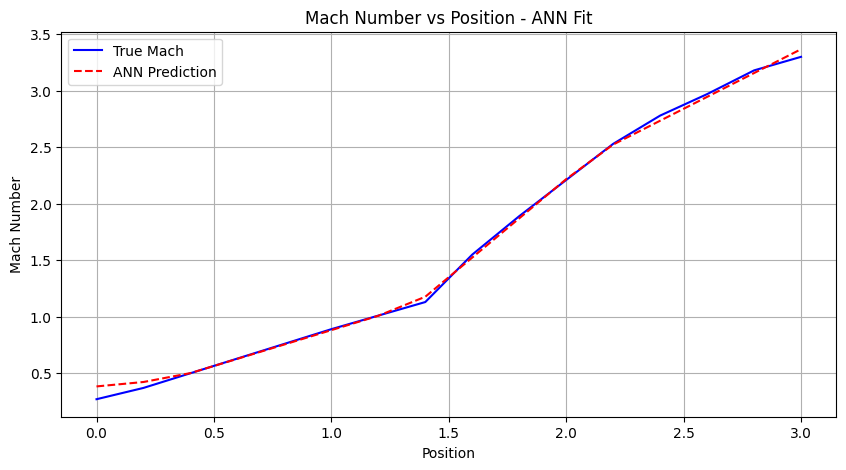

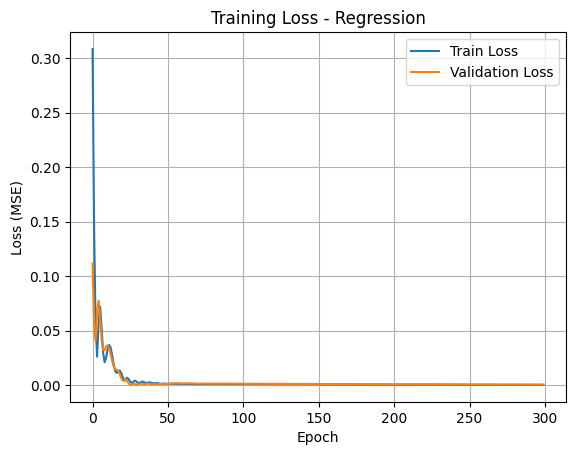

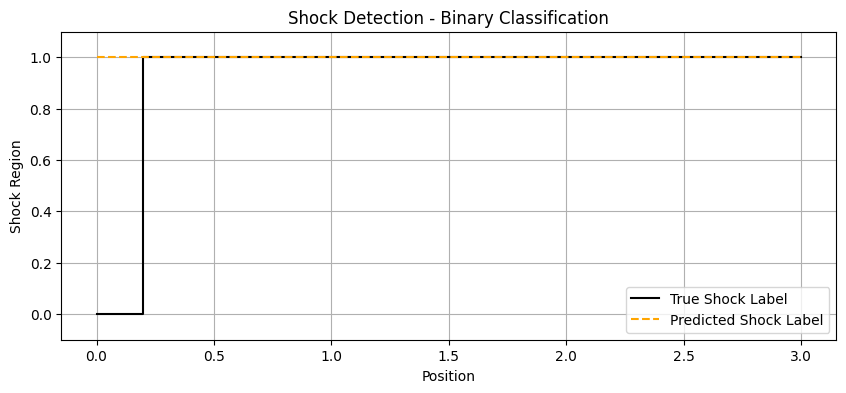

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam


x_data = np.array([
    0.00, 0.20, 0.40, 0.60, 0.80, 1.00, 1.20, 1.40, 1.60, 1.80, 2.00,
    2.20, 2.40, 2.60, 2.80, 3.00
]).reshape(-1, 1)

mach_data = np.array([
    0.27, 0.37, 0.50, 0.63, 0.76, 0.89, 1.01, 1.13, 1.55, 1.89, 2.21,
    2.53, 2.78, 2.97, 3.18, 3.30
]).reshape(-1, 1)


mach_gradient = np.gradient(mach_data.flatten(), x_data.flatten())
shock_threshold = 0.5
shock_labels = (np.abs(mach_gradient) > shock_threshold).astype(int).reshape(-1, 1)

#Scale inputs and outputs
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

x_scaled = x_scaler.fit_transform(x_data)
y_scaled = y_scaler.fit_transform(mach_data)

#Train-test split for regression
x_train, x_test, y_train, y_test = train_test_split(
    x_scaled, y_scaled, test_size=0.2, random_state=42
)

#Mach regression model
reg_model = Sequential([
    Dense(32, input_dim=1, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])
reg_model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
reg_history = reg_model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=300, verbose=0)

# Predict Mach number
y_pred_scaled = reg_model.predict(x_scaled)
y_pred = y_scaler.inverse_transform(y_pred_scaled)

#Train-test split for shock classifier
x_train_cls, x_test_cls, y_train_cls, y_test_cls = train_test_split(
    x_scaled, shock_labels, test_size=0.2, random_state=42
)

#Shock classifier model
cls_model = Sequential([
    Dense(16, input_dim=1, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])
cls_model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])
cls_history = cls_model.fit(x_train_cls, y_train_cls, validation_data=(x_test_cls, y_test_cls), epochs=200, verbose=0)

#Predict shock region
shock_pred = (cls_model.predict(x_scaled) > 0.5).astype(int).flatten()

#Plot Mach fit
plt.figure(figsize=(10, 5))
plt.plot(x_data, mach_data, label='True Mach', color='blue')
plt.plot(x_data, y_pred, label='ANN Prediction', linestyle='--', color='red')
plt.xlabel("Position")
plt.ylabel("Mach Number")
plt.title("Mach Number vs Position - ANN Fit")
plt.legend()
plt.grid(True)
plt.show()

# Plot training loss (regression)
plt.figure()
plt.plot(reg_history.history['loss'], label='Train Loss')
plt.plot(reg_history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.title("Training Loss - Regression")
plt.grid(True)
plt.show()

#shock detection plot
plt.figure(figsize=(10, 4))
plt.plot(x_data, shock_labels, label='True Shock Label', drawstyle='steps-post', color='black')
plt.plot(x_data, shock_pred, label='Predicted Shock Label', linestyle='--', drawstyle='steps-post', color='orange')
plt.xlabel("Position")
plt.ylabel("Shock Region")
plt.title("Shock Detection - Binary Classification")
plt.legend()
plt.grid(True)
plt.ylim(-0.1, 1.1)
plt.show()